In [1030]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions as adfn
import CCM as cfn
import EDM as efn

# Define paths
#----------------------------------------------------------------------
Fcode = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
Fdata = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
Fdoc = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/Data2process/Project/' 
F10t2 = '/Volumes/Dominic 10tb2/Data2process/Project/' 
Ftm = '/Volumes/Dominic Time Machine/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'


%load_ext autoreload
sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

# Visualise Data 

In [693]:
prac_l = adfn.return_files(Fdata, 'PTZ-WILDTYPE-CCM', '*xmap*')
trace_l = adfn.return_files(Fdata, 'PTZ-WILDTYPE-CCM', '*pre*')
trace_l[1], prac_l[0]


('PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01_cuttrace_pre-CCM.npy',
 'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01_cuttrace_trace_CCMxmap.h5')

In [697]:
import h5py
xmap = h5py.File(prac_l[0])
e = np.array(xmap['e'])[1:]
tr = np.load(trace_l[1], allow_pickle=True).item()['trace']
e.shape, tr.shape

/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


((11038,), (11038, 800))

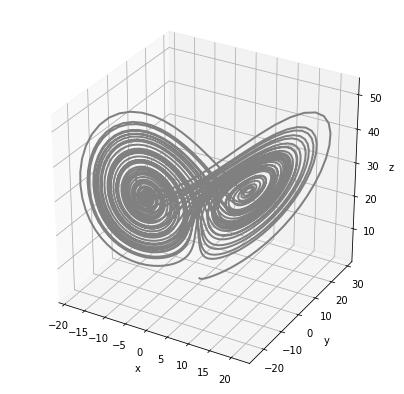

In [744]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dt = 0.01
steps = 5000
sigma = 10
r = 28
b = 2.667
xs = np.empty(steps + 1)
ys = np.empty(steps + 1)
zs = np.empty(steps + 1)

# Set starting values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Calculate the partial derivatives at each t, then estimate t+1
for i in range(steps):
    x_d, y_d, z_d = efn.Lorenz(xs[i], ys[i], zs[i], sigma, r, b)
    xs[i + 1] = xs[i] + (x_d * dt)
    ys[i + 1] = ys[i] + (y_d * dt)
    zs[i + 1] = zs[i] + (z_d * dt)

# Visualise
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs, ys, zs, lw=2, c = 'grey')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

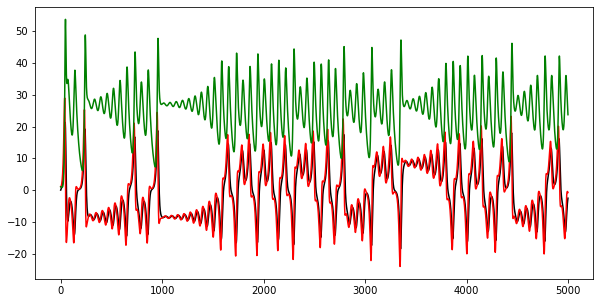

In [403]:
fig = plt.figure(figsize=(10,5))
plt.plot(xs, c = 'k')
plt.plot(ys, c = 'red')
plt.plot(zs, c = 'green')

# Estimate time lag

In [560]:
data = ys

Tau = 15


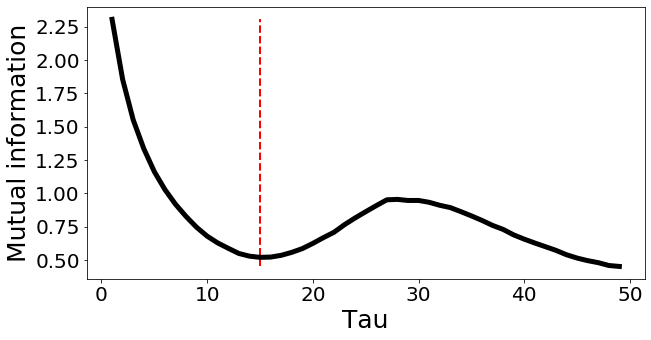

In [674]:
# Find tau = time delays that are maximally independent - how can we provide max information for each dimension?
# Find the first minima in the mutual information function between 2 timeseries lagged by tau
# The first minima should represent the tau at which the time series are both maximally independent without , 
# so this delay will provide extra information when performing the embedding without losing the correlation completely. 
data = zs

from scipy.signal import argrelextrema

tau = efn.find_tau(data, 'mi') #find the first minima of MI function


MI_list = []
tau_range = 50 #Tau to loop over

#Calculate MI over a range of tau
for i in range(1,tau_range):
    MI_list = np.append(MI_list,[efn.MI(data,i,50)])
print('Tau = ' + str(tau))

fig = plt.figure(figsize = (10,5))
plt.plot(range(1,tau_range), MI_list, c = 'k', lw = 5)
plt.vlines(x=tau,  alpha = 1, ymin = np.min(MI_list), ymax = np.max(MI_list), color = 'red', linewidth = 2, linestyle = '--')
plt.ylabel("Mutual information", size = 25)
plt.xlabel("Tau", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.savefig(Ffig + 'tau_MI.png')
plt.show()

Tau = 25


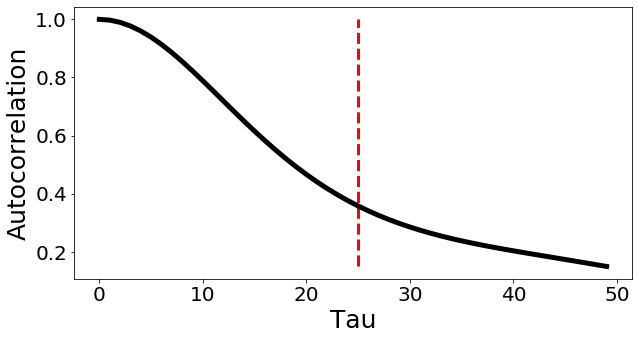

In [405]:
# Find tau = the tau at which the autocorrelation drops below 1/e
tau = efn.find_tau(data, 'ac') 

print('Tau = ' + str(tau))

auto = adfn.autocorr(data, 50)
fig = plt.figure(figsize = (10,5))
plt.plot(range(0,len(auto)), auto, c = 'k', lw = 5)
plt.vlines(x=tau,  alpha = 1, ymin = np.min(auto), ymax = np.max(auto), color = 'red', linewidth = 3, linestyle = '--')
plt.ylabel("Autocorrelation", size = 25)
plt.xlabel("Tau", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.savefig(Ffig + 'tau_MI.png')
plt.show()

# Estimate embedding dimension

In [512]:
data = tr[0]
tau = 1

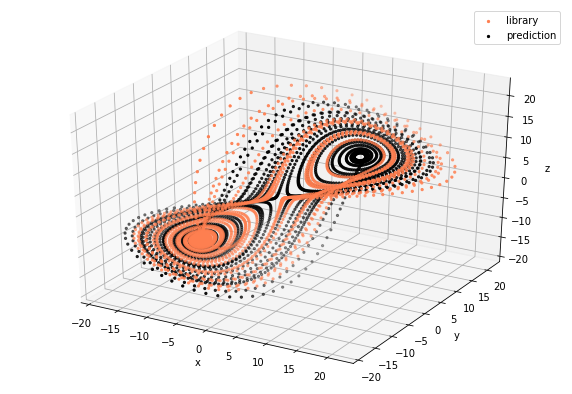

In [601]:
# Visualise library and prediction
data = xs
e = 3
Tau = 9
#Visualise library and prediction
lib = data[:data.shape[0]//2]
pred = data[data.shape[0]//2:]

# Build manifold with given E and tau
lib_m = efn.takens_embed(e, Tau, lib)
pred_m = efn.takens_embed(e, Tau, pred)

#Visualise 
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(lib_m[:,0],lib_m[:,1], lib_m[:,2], s=5, c = 'coral', label = 'library')
ax.scatter3D(pred_m[:,0],pred_m[:,1], pred_m[:,2], s=5, c = 'k', label = 'prediction')

ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

Text(0.5, 0, 'z')

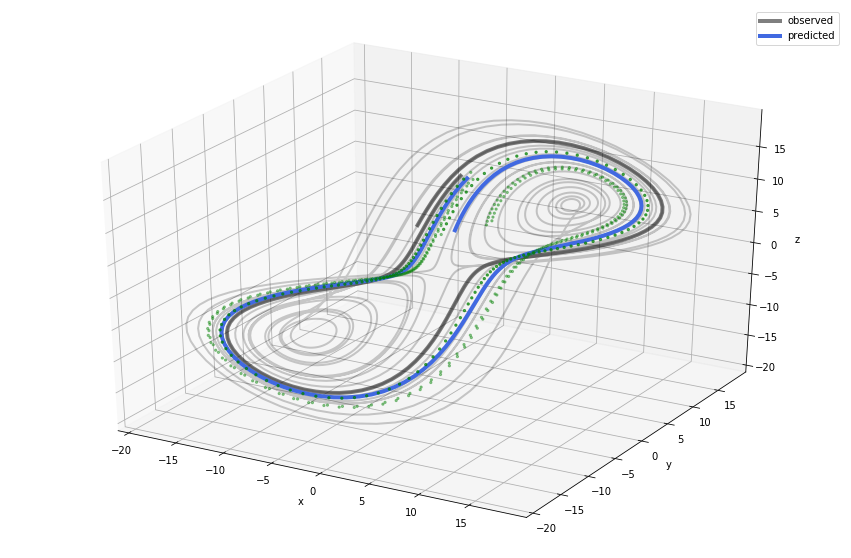

In [665]:
#Visualise simplex projection
#SIMPLEX - uses the distances of point of interest i to its n nearest neighbours at t0, to then calculate the 
# position of point i at timepoint t+n - this is done by finding the positions of the same neighbours at 
# t+n and using the initial distances to i to predict i at t+n - IT ASSUMES LOCAL NEIGHBOURHOOD STRUCTURE IS CONSERVED IN FUTURE. 

from scipy import spatial

num = 0
t_start = 0
t_end = 150

x_tp_pred_m = np.zeros((len(range(t_start,t_end)), 3))

#find the E+1 nearest neighbours in library
dist_mat = spatial.distance_matrix(pred_m, lib_m) #compute distances between all points
nn_num = E+1 #how many nearest neighbours to find
current_point = pred_m[num]
curr_dist = dist_mat[num]
nn_ind = sorted(range(len(curr_dist)), key=lambda k: curr_dist[k])[:nn_num] #return indeces of nearest neighbours in library
nn = lib_m[nn_ind] #positions of nearest neighbours in library, to current point in pred at t0
nn_dist = dist_mat[num, nn_ind]  #distances of each nn to our pred point
w_mat = np.exp(-1*(nn_dist/np.min(nn_dist))) #matrix of weights for each nn 


from matplotlib import cm
colormap = cm.coolwarm(np.linspace(0, 1, len(range(t_start,t_end))))

#Plot observed manifold
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pred_m[:,0],pred_m[:,1], pred_m[:,2], c = 'k', alpha = 0.2, lw = 2)

#ax.scatter3D(current_point[0],current_point[1], current_point[2], s=20, c = 'red', label = 'Point of interest')
#ax.scatter3D(nn[:,0],nn[:,1],nn[:,2], s=5, c = 'k')


# Loop in time and predict
for t in range(t_start, t_end):
    # Where do nn end up at t + n
    nn_ind_tp = np.array(nn_ind) + t #find indeces of neighbours in the future for simplex projection
    nn_tp = lib_m[nn_ind_tp] # locations of neighbours in future
    x_tp = pred_m[num][0] #Point I am trying to predict 
    x_tp_pred = 0
    for nn_i in range(w_mat.shape[0]): #Loop through each nn and sum over the weight*position at tp
        x_tp_pred+= (w_mat[nn_i]/np.sum(w_mat))*nn_tp[nn_i]
    
    x_tp_pred_m[t] = x_tp_pred  
    
    #Plot nearest neighbours use to calculate position
    ax.scatter3D(nn_tp[:,0],nn_tp[:,1],nn_tp[:,2], s=5, c ='green', alpha = 0.4)
    
#Plot observed manifold
ax.plot(pred_m[t_start:t_end,0],pred_m[t_start:t_end,1], pred_m[t_start:t_end,2], c = 'k', label = 'observed', alpha = 0.5, lw = 4)
ax.plot(x_tp_pred_m[:,0], x_tp_pred_m[:,1],x_tp_pred_m[:,2], c = 'royalblue', lw = 4, label = 'predicted')    
ax.legend()

In [529]:
# Find E = simplex project
# Find the E at which the nearest neighbours at E+1 retain their positions 
# Assumption that beyond a certain E the structure of the attractor become stable

E = efn.find_E(data, tau, 'simplex')
print(E)

6


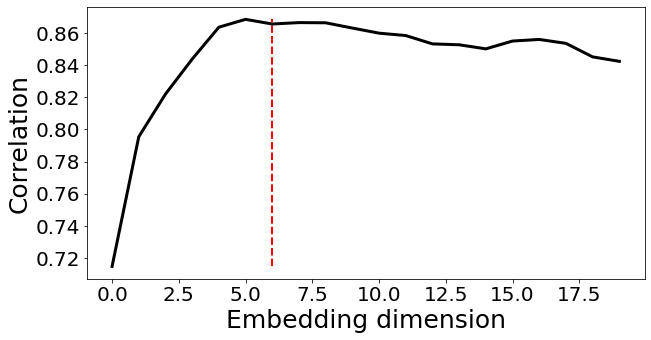

In [530]:
# Find E = simplex project
# Visualise E vs prediction score

E_range = 20 
t = 1 

corr_l = [0]*E_range
for e in range(1, E_range+1):
    corr_l[e-1] = efn.simplex_project(data, e, tau, t)[0]
E_max = np.where(corr_l == np.max(corr_l))[0][0] + 1
fig = plt.figure(figsize = (10,5))
plt.plot(corr_l, c = 'k', lw = 3)
plt.vlines(x=E_max,  alpha = 1, ymin = np.min(corr_l), ymax = np.max(corr_l), color = 'red', linewidth = 2, linestyle = '--')

plt.xlabel("Embedding dimension", size = 25)
plt.ylabel("Correlation", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.savefig(Ffig + 'simplex_E.svg')
plt.show()

Prediction accuracy = 0.868565031816483


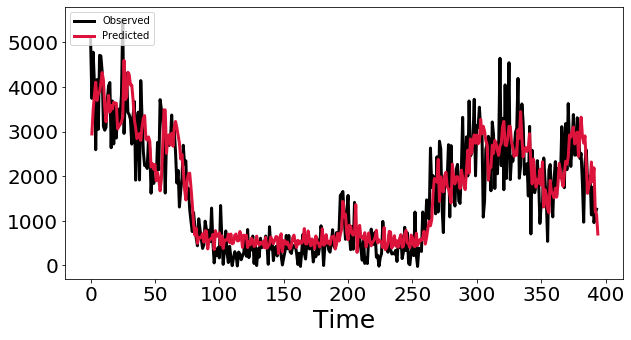

In [531]:
# Find E = simplex project
# Visualise observed vs predicted time series

corr, [obs,pred] = efn.simplex_project(data, E, tau, 1)
print('Prediction accuracy = ' + str(corr))

fig = plt.figure(figsize = (10,5))
plt.plot(obs, c = 'k', lw = 3, label = 'Observed')
plt.plot(pred, c = 'crimson', lw = 3, alpha = 1, label = 'Predicted')

plt.xlabel("Time", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc = 2)
#plt.savefig(Ffig + 'simplex_timeseries.svg')
plt.show()

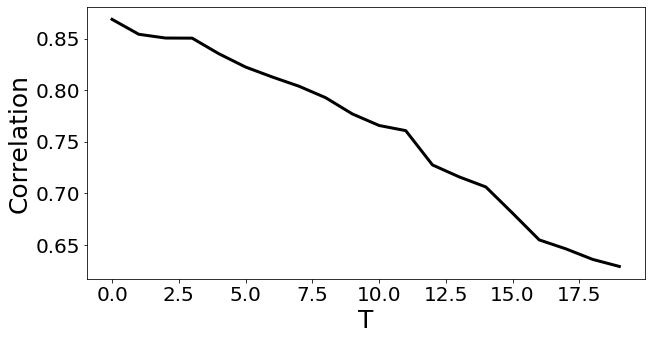

In [545]:
# Estimating chaoticity of time series using simplex projection
# Over increasing t how does the prediction get worse

t_range = 20

corr_l = [0]*t_range
pred_l = [0]*t_range

for t in range(1, t_range+1):
    corr_l[t-1], pred_l[t-1] = efn.simplex_project(data, E, tau, t)
    
fig = plt.figure(figsize = (10,5))
plt.plot(corr_l, c = 'k', lw = 3)

plt.xlabel("T", size = 25)
plt.ylabel("Correlation", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.savefig(Ffig + 'simplex_E.svg')
plt.show()



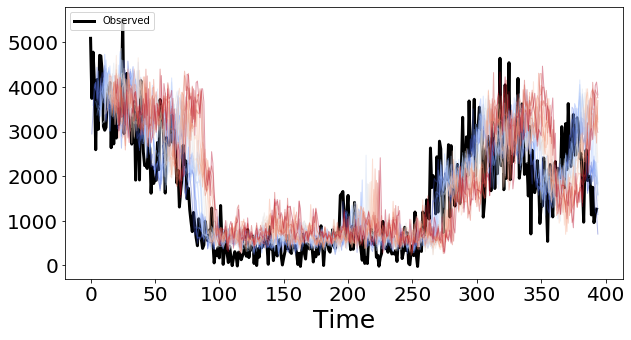

In [558]:
# Find E = simplex project
# How does the prediction do as you increase time steps into the future?

from matplotlib import cm

cmap = cm.coolwarm(np.linspace(0,1,len(pred_l)))

fig = plt.figure(figsize = (10,5))
plt.plot(pred_l[0][0], c = 'k', lw = 3, label = 'Observed')

for p in range(len(pred_l)):
    plt.plot(pred_l[p][1], c = cmap[p], lw = 1, alpha = 0.4)

plt.xlabel("Time", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc = 2)
#plt.savefig(Ffig + 'simplex_timeseries.svg')
plt.show()

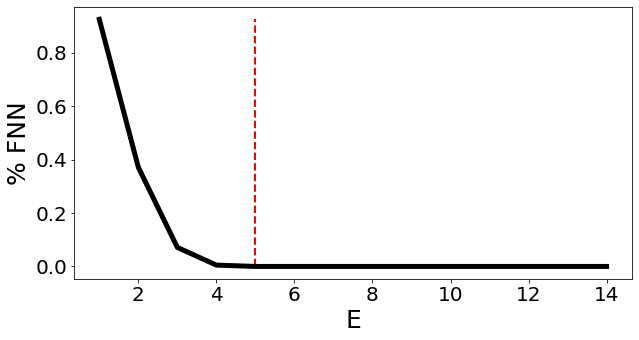

5


In [528]:
# Find E = false nearest neighbours
# Find the E at which the nearest neighbours at E+1 retain their positions 
# assumption that beyond a certain E the structure of the attractor become stable

E = efn.find_E(data, tau, 'fnn')

nFNN = []
for i in range(1,15):
    nFNN.append(efn.FNN(data,tau,i, 10) / len(data))

fig = plt.figure(figsize = (10,5))
plt.plot(range(1,15), nFNN, c = 'k', lw = 5)
plt.vlines(x=E,  alpha = 1, ymin = np.min(nFNN), ymax = np.max(nFNN), color = 'red', linewidth = 2, linestyle = '--')
plt.ylabel("% FNN", size = 25)
plt.xlabel("E", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.savefig(Ffig + 'tau_MI.png')
plt.show()

print(E)

# Convergent Cross Mapping

In [1034]:
#BUILD CCM
#How are 2 variables causally related? 
#Can we use shadow manifold X to predict Y, and vice versa?
#Causal flow: if Mx-->Y, then Y causes X; if My-->X, then X causes Y

l_range = np.arange(20, 800, 5) #library size range
X_Y = cfn.CCM(xs, ys).conv_cross_map('mi', 'simplex', '', l_range).ccm_corr_l #X causing Y
Y_X = cfn.CCM(ys, xs).conv_cross_map('mi', 'simplex', '', l_range).ccm_corr_l #Y causing X

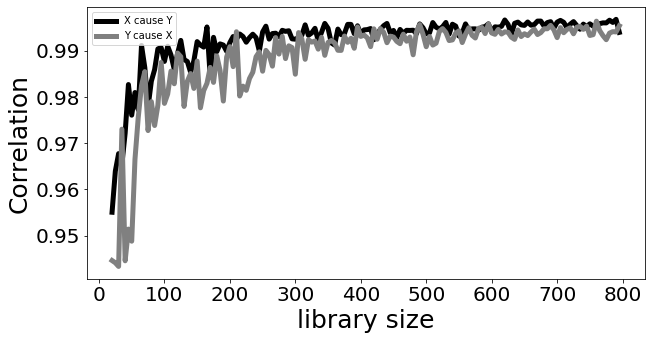

In [1035]:
fig = plt.figure(figsize = (10,5))
plt.plot(l_range,X_Y, c = 'k', lw = 5, label = 'X cause Y')
plt.plot(l_range,Y_X, c = 'grey', lw = 5, label = 'Y cause X')

plt.ylabel("Correlation", size = 25)
plt.xlabel("library size", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend()
plt.show()


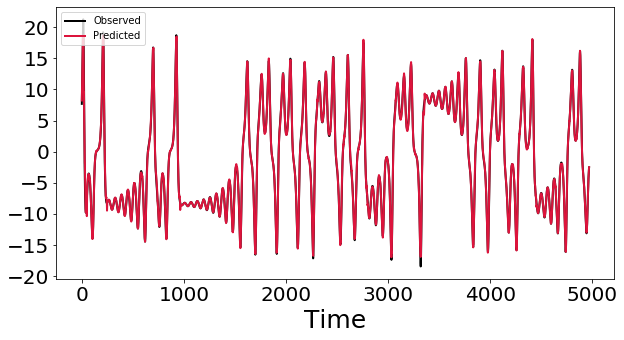

In [1012]:
# CCM - cross map from one manifold to another to build prediction
# Visualise observed vs predicted time series

#Define variables - NB parameters may be different across each variable
cause = {'data': xs, 'E': 3, 'tau': 15} #variable being tested as causative factor - ie pred manifold
effect = {'data': ys, 'E': 3, 'tau': 15} #variable being tested as the effected variables - ie lib manifold


lib, lib_E, lib_tau = effect['data'], effect['E'], effect['tau'] # This is the variable that will be used to predict -  the effected variable.
pred, pred_E, pred_tau = cause['data'], cause['E'], cause['tau'] # This is the variable that will be predicted - the causative variable. 
lib_m = efn.takens_embed(lib_E, lib_tau, lib) 
pred_m = efn.takens_embed(pred_E, pred_tau, pred) 

#Cross map across full manifolds
#=====================================
obs,pred = efn.crossmap(lib_m, pred_m) 

fig = plt.figure(figsize = (10,5))
plt.plot(obs, c = 'k', lw = 2, label = 'Observed')
plt.plot(pred, c = 'crimson', lw = 2, alpha = 1, label = 'Predicted')

plt.xlabel("Time", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc = 2)
plt.show()

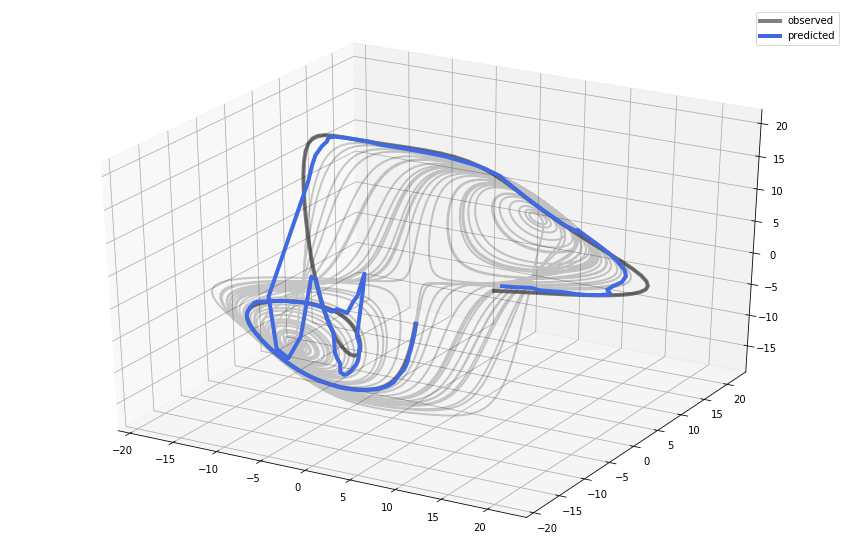

In [722]:
# CCM - cross map from one manifold to another to build prediction
# Visualise CCM

#Define plotting parameters
#===========================
t_start = 0
t_end = 150

#Define variables to visualise
#==========================
lib, lib_E, lib_tau = effect['data'], effect['E'], effect['tau'] # This is the variable that will be used to predict -  the effected variable.
pred, pred_E, pred_tau = cause['data'], cause['E'], cause['tau'] # This is the variable that will be predicted - the causative variable. 
lib_m = efn.takens_embed(lib_E, lib_tau, lib) 
pred_m = efn.takens_embed(pred_E, pred_tau, pred) 

x_m = np.zeros((len(range(t_start,t_end)), 3)) #Matrix to enter values you are trying to predict
x_pred_m = np.zeros((len(range(t_start,t_end)), 3))

x_m[:], x_pred_m[:] = np.nan, np.nan #Make all nan to deal with empty values

from matplotlib import cm
colormap = cm.coolwarm(np.linspace(0, 1, len(range(t_start,t_end))))

#Plot observed manifold
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pred_m[:,0],pred_m[:,1], pred_m[:,2], c = 'k', alpha = 0.2, lw = 2)

#find the E+1 nearest neighbours in library
dist_mat = spatial.distance_matrix(lib_m, lib_m) #compute distances between all points against themselves
nn_num = lib_m.shape[1]+1 #how many nearest neighbours to find

#Loop through each time step in lib
for t in range(t_start, t_end):
    # Find nearest neighbours in library for current point in library
    current_point = lib_m[t]
    curr_dist = dist_mat[t]
    nn_ind = sorted(range(len(curr_dist)), key=lambda k: curr_dist[k])[:nn_num+1][1:] #return indeces 

    nn = lib_m[nn_ind] #positions of nearest neighbours in library, to current point in lib
    nn_pred = pred_m[nn_ind] #positions of points in pred, labelled by indeces of nearest neighbours in lib to point in lib

    #Reconstruct pred point
    #Use weights calculated from distances between lib point and its nearest neighbours in lib
    #Use coordinates of pred points sharing time indeces with lib nearest neighbours

    #CALCULATE WEIGHTS
    nn_dist = dist_mat[t, nn_ind]  #distances of each nn to our pred point
    w_mat = np.exp(-1*(nn_dist/np.min(nn_dist))) #matrix of weights for each nn 

    #SUM OVER ALL PRED POINTS
    x_ = pred_m[t] # Value I am trying to predict
    x_pred = 0 # Predicted value
    for nn_i in range(w_mat.shape[0]): #Loop through each nn in lib and sum over the weight*position in pred
        x_pred+= (w_mat[nn_i]/np.sum(w_mat))*nn_pred[nn_i]
    x_pred = x_pred #project back into 1d space

    #Populate vectors
    x_m[t] = x_
    x_pred_m[t] = x_pred
    
#Plot observed and predicted manifolds
ax.plot(x_m[:,0],x_m[:,1], x_m[:,2], c = 'k', label = 'observed', alpha = 0.5, lw = 4)
ax.plot(x_pred_m[:,0], x_pred_m[:,1],x_pred_m[:,2], c = 'royalblue', lw = 4, label = 'predicted')    
ax.legend()


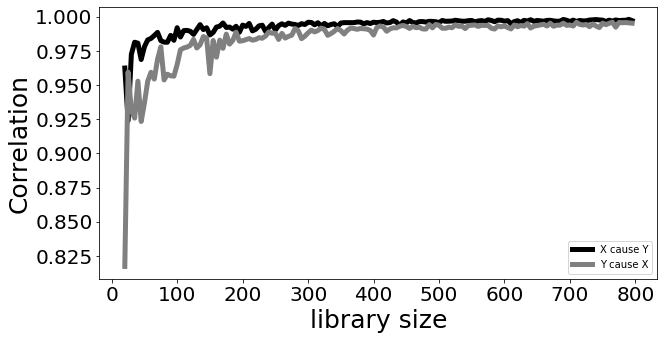

In [1013]:
#CONVERGENT cross mapping
# CCM is performed over a range of library sizes to check for convergence - the property that if the
# supposed causative variable actually causes the supposed effected variable the correlation between 
# CCM predictions and observed manifold values should increase as more points are added. 

l_range = np.arange(20, 800, 5) #library size range

# X cause Y
#========================================
cause = {'data': xs, 'E': 3, 'tau': 15} #variable being tested as causative factor - ie pred manifold
effect = {'data': ys, 'E': 3, 'tau': 15} #variable being tested as the effected variables - ie lib manifold
X_Y, _, _ = efn.CCM_range(l_range, cause, effect) #Run CCM over library range


# Y cause X
#========================================
cause = {'data': ys, 'E': 3, 'tau': 15} #variable being tested as causative factor - ie pred manifold
effect = {'data': xs, 'E': 3, 'tau': 15} #variable being tested as the effected variables - ie lib manifold
Y_X, _, _ = efn.CCM_range(l_range, cause, effect) #Run CCM over library range


fig = plt.figure(figsize = (10,5))
plt.plot(l_range,X_Y, c = 'k', lw = 5, label = 'X cause Y')
plt.plot(l_range,Y_X, c = 'grey', lw = 5, label = 'Y cause X')

plt.ylabel("Correlation", size = 25)
plt.xlabel("library size", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend()
plt.show()


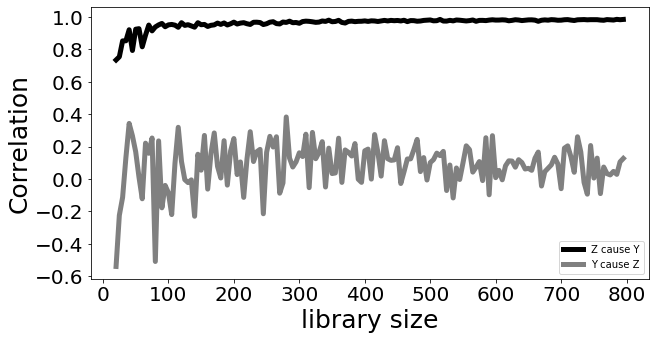

In [760]:
#CONVERGENT cross mapping
# CCM is performed over a range of library sizes to check for convergence - the property that if the
# supposed causative variable actually causes the supposed effected variable the correlation between 
# CCM predictions and observed manifold values should increase as more points are added. 

l_range = np.arange(20, 800, 5) #library size range

# X cause Y
cause = {'data': zs, 'E': 3, 'tau': 15} #variable being tested as causative factor - ie pred manifold
effect = {'data': ys, 'E': 3, 'tau': 15} #variable being tested as the effected variables - ie lib manifold
Z_Y, _, _ = efn.CCM_range(l_range, cause, effect)

# Y cause X
cause = {'data': ys, 'E': 3, 'tau': 15} #variable being tested as causative factor - ie pred manifold
effect = {'data': zs, 'E': 3, 'tau': 15} #variable being tested as the effected variables - ie lib manifold
Y_Z, _, _ = efn.CCM_range(l_range, cause, effect)


fig = plt.figure(figsize = (10,5))
plt.plot(l_range,Z_Y, c = 'k', lw = 5, label = 'Z cause Y')
plt.plot(l_range,Y_Z, c = 'grey', lw = 5, label = 'Y cause Z')

plt.ylabel("Correlation", size = 25)
plt.xlabel("library size", size = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend()
plt.show()
